type: <class 'pandas.core.frame.DataFrame'> shape: (10000, 19)
type: <class 'pandas.core.frame.DataFrame'> shape: (10000, 19)
type: <class 'pandas.core.frame.DataFrame'> shape: (10000, 19)
type: <class 'pandas.core.frame.DataFrame'> shape: (10000, 19)
type: <class 'pandas.core.frame.DataFrame'> shape: (10000, 19)
type: <class 'pandas.core.frame.DataFrame'> shape: (10000, 19)
type: <class 'pandas.core.frame.DataFrame'> shape: (10000, 19)
type: <class 'pandas.core.frame.DataFrame'> shape: (9673, 19)


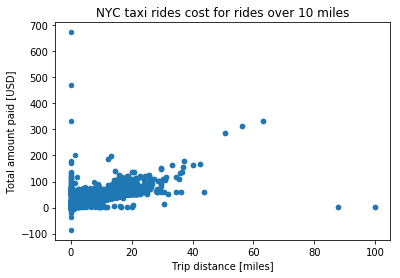

yellow_tripdata_2015-01.csv
yellow_tripdata_2015-02.csv
yellow_tripdata_2015-03.csv
   n_long  n_total
0   35321   201524
The percentage of long trips longer than 20 minutes is
0    17.526945
dtype: float64


In [15]:
# In this project we make use of decorators,and the dask module.
# We have 3 dataset of taxi rides from NYC.
# We want to find the percentage of rides that are longer than 10 miles.

import pandas as pd
import matplotlib.pyplot as plt
from dask import delayed

# 1. Read big data sets in chunks.

filename = 'yellow_tripdata_2015-01.csv'
for chunk in pd.read_csv(filename, chunksize=10000):
    print('type: %s shape: %s' % (type(chunk),chunk.shape))

def filter_is_long_trip(data):
    """Returns DataFrame filtering trips that are longer than 10 miles"""
    is_long_trip=(data.trip_distance>10)
    return data.loc[is_long_trip]
    
chunks=[chunk.append(filter_is_long_trip(chunk)) for chunk in pd.read_csv(filename, chunksize=1000)]
# or with the generator list comprehension
# chunks=(chunk.append(filter_is_long_trip(chunk)) for chunk in pd.read_csv(filename, chunksize=1000))
# In this way the elements are generated oone at a time, and they are never in the memory silmutaneously.

lenghts=[len(chunk) for chunk in chunks]
long_trip_df=pd.concat(chunks)
long_trip_df.shape

# Create a scatteroplot of NYC taxi rides cost for rides over 10 miles
long_trip_df.plot.scatter(x='trip_distance',y='total_amount')
plt.xlabel('Trip distance [miles]')
plt.ylabel('Total amount paid [USD]')
plt.title('NYC taxi rides cost for rides over 10 miles')
plt.show()


# 2. Now we will use generator to read the 3 csv files.

template='yellow_tripdata_2015-{:02d}.csv'
filenames=(template.format(k) for k in range(1,4)) #Generator
for fname in filenames:                            #Examine contents
    print(fname)


# 3. Now we will compute the fraction of long trips longer than 20 minutes.

def count_long_trips(df):
    """Filters trips longer than 20 minutes and counts the total number of trips"""
    df['duration']=(df.tpep_dropoff_datetime-df.tpep_pickup_datetime).dt.seconds
    is_long_trip=df.duration>1200
    result_dict={"n_long":[sum(is_long_trip)],"n_total":[len(df)]}
    return pd.DataFrame(result_dict)

filenames=[template.format(k) for k in range(1,4)]                        #List Comprehension
dataframes=(pd.read_csv(fname,parse_dates=[1,2]) for fname in filenames)  #Generator
totals= (count_long_trips(df) for df in dataframes)                       #Generator
annual_totals=sum(totals)                                                 #Consumes generators
print(annual_totals)

fraction=annual_totals['n_long'] / annual_totals['n_total']
print('The percentage of long trips longer than 20 minutes is')
print(fraction*100)


In [16]:
# Now we will use the dask module to makes things go faster.

from dask import delayed
template='yellow_tripdata_2015-{:02d}.csv'
filenames=[template.format(k) for k in range(1,4)] # List comprehension

@delayed
def count_long_trips(df):
    """Filters trips longer than 20 minutes and counts the total number of trips"""
    df['duration']=(df.tpep_dropoff_datetime-df.tpep_pickup_datetime).dt.seconds
    is_long_trip=df.duration>1200
    result_dict={"n_long":[sum(is_long_trip)],"n_total":[len(df)]}
    return pd.DataFrame(result_dict)

@delayed
def read_file(fname):
    return pd.read_csv(fname,parse_dates=[1,2])

totals = [count_long_trips(read_file(fname)) for fname in filenames] 
annual_totals=sum(totals)
annual_totals=annual_totals.compute()
                       
                       
fraction=annual_totals['n_long'] / annual_totals['n_total']
print('The percentage of long trips lonfer than 20 minutes is')
print(fraction*100)


The percentage of long trips lonfer than 20 minutes is
0    17.526945
dtype: float64
